### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

# Combine text and numerical features
from scipy.sparse import hstack

from imblearn.over_sampling import SMOTE

### 1. Analyze the Dataset

In [2]:
# Load the dataset
df = pd.read_csv('train_product_data.csv')

# View data structure
df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,Clothing,SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,Footwear,SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
2,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,Clothing,SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
3,ce5a6818f7707e2cb61fdcdbba61f5ad,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,Clothing,SRTEH2FVVKRBAXHB,1199.0,479.0,"[""http://img6a.flixcart.com/image/short/p/j/z/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,29c8d290caa451f97b1c32df64477a2c,2016-03-25 22:59:23 +0000,http://www.flipkart.com/dilli-bazaaar-bellies-...,"dilli bazaaar Bellies, Corporate Casuals, Casuals",Footwear,SHOEH3DZBFR88SCK,699.0,349.0,"[""http://img6a.flixcart.com/image/shoe/b/p/n/p...",False,"Key Features of dilli bazaaar Bellies, Corpora...",No rating available,No rating available,dilli bazaaar,"{""product_specification""=>[{""key""=>""Occasion"",..."


In [3]:
# View data structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  14999 non-null  object 
 1   crawl_timestamp          14999 non-null  object 
 2   product_url              14999 non-null  object 
 3   product_name             14999 non-null  object 
 4   product_category_tree    14999 non-null  object 
 5   pid                      14999 non-null  object 
 6   retail_price             14942 non-null  float64
 7   discounted_price         14942 non-null  float64
 8   image                    14996 non-null  object 
 9   is_FK_Advantage_product  14999 non-null  bool   
 10  description              14998 non-null  object 
 11  product_rating           14999 non-null  object 
 12  overall_rating           14999 non-null  object 
 13  brand                    10289 non-null  object 
 14  product_specifications

In [4]:
# Check for missing values
print(df.isnull().sum())

uniq_id                       0
crawl_timestamp               0
product_url                   0
product_name                  0
product_category_tree         0
pid                           0
retail_price                 57
discounted_price             57
image                         3
is_FK_Advantage_product       0
description                   1
product_rating                0
overall_rating                0
brand                      4710
product_specifications        6
dtype: int64


In [5]:
# View unique values in 'product_category_tree' to understand class distribution
print(df['product_category_tree'].value_counts())

product_category_tree
Clothing                       5316
Jewellery                      3218
Footwear                       1083
Automotive                      937
Mobiles & Accessories           768
Home Decor & Festive Needs      714
Kitchen & Dining                610
Computers                       531
Watches                         526
Tools & Hardware                379
Toys & School Supplies          271
Pens & Stationery               264
Baby Care                       224
Bags, Wallets & Belts           158
Name: count, dtype: int64


##### Merge these two small categories(Toys & School Supplies, Pens & Stationery) in on combined category(Toys & Stationery) for more precise work

In [6]:
# Strip any leading/trailing spaces and apply a case-insensitive search
df['product_category_tree'] = df['product_category_tree'].str.strip()

# Use str.contains for a flexible match and merge categories
df['product_category_tree'] = df['product_category_tree'].apply(lambda x: "Toys & Stationery" 
                                                                if "Toys & School Supplies" in x or "Pens & Stationery" in x
                                                                else x)

# Verify the change
print(df['product_category_tree'].value_counts())


product_category_tree
Clothing                      5316
Jewellery                     3218
Footwear                      1083
Automotive                     937
Mobiles & Accessories          768
Home Decor & Festive Needs     714
Kitchen & Dining               610
Toys & Stationery              535
Computers                      531
Watches                        526
Tools & Hardware               379
Baby Care                      224
Bags, Wallets & Belts          158
Name: count, dtype: int64


### 2. Visualize the Data

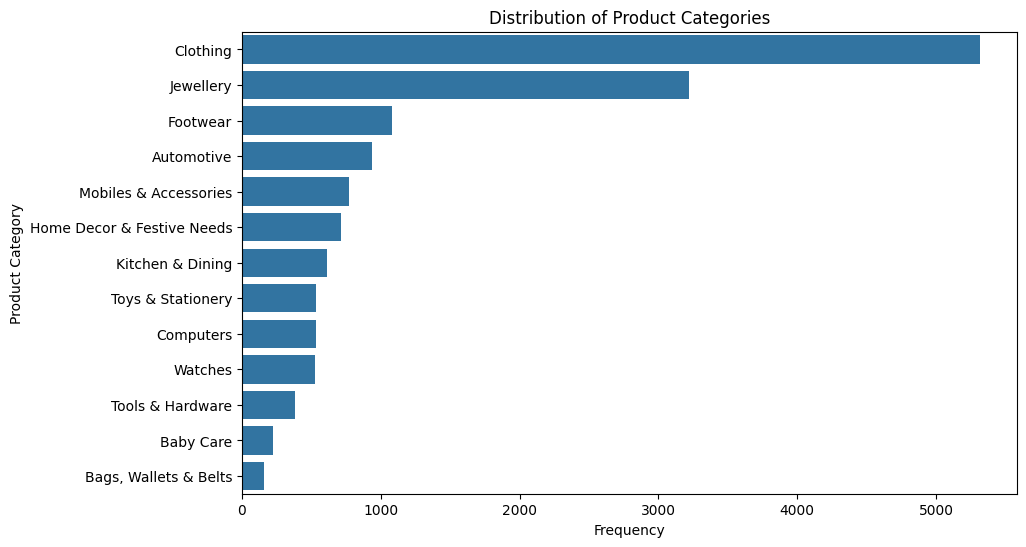

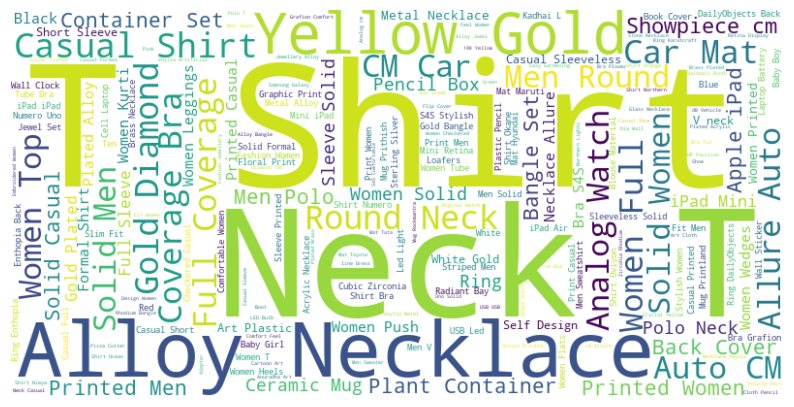

In [7]:
# Plot class distribution
plt.figure(figsize=(10, 6))
sns.countplot(y='product_category_tree', data=df, order=df['product_category_tree'].value_counts().index)
plt.title('Distribution of Product Categories')
plt.xlabel('Frequency')
plt.ylabel('Product Category')
plt.show()

# Word cloud for 'product_name' to observe common keywords
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(df['product_name'].astype(str)))
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


### 3. Preprocess the Data

##### Cleaning Text Data

In [8]:
# Define a function for cleaning text data
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    return text

# Apply the cleaning function to relevant text columns
df['product_name'] = df['product_name'].fillna('').apply(clean_text)
df['description'] = df['description'].fillna('').apply(clean_text)
df['product_category_tree'] = df['product_category_tree'].fillna('').apply(clean_text)

##### Handling Missing Values

In [9]:
# Fill numerical columns with suitable values
df['retail_price'] = df['retail_price'].fillna(df['retail_price'].median())
df['discounted_price'] = df['discounted_price'].fillna(df['discounted_price'].median())

### 4. Feature Engineering / Text to Features

In [10]:
# Combine 'product_name' and 'description' for text features
df['combined_text'] = df['product_name'] + " " + df['description']

# Convert text data to TF-IDF features
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_text = tfidf.fit_transform(df['combined_text'])

# Combine text and numerical features
# X_num = df[['retail_price', 'discounted_price']]
# X = hstack([X_text, X_num])
X = X_text
y = df['product_category_tree']


### 5. Address Class Imbalance

In [11]:
# Check class distribution
print(df['product_category_tree'].value_counts())

# Apply SMOTE to balance classes
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


product_category_tree
clothing                     5316
jewellery                    3218
footwear                     1083
automotive                    937
mobiles  accessories          768
home decor  festive needs     714
kitchen  dining               610
toys  stationery              535
computers                     531
watches                       526
tools  hardware               379
baby care                     224
bags wallets  belts           158
Name: count, dtype: int64


### 6. Develop Machine Learning Models - Multi-Class Text Classifier

In [12]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Initialize models
models = {
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Linear SVM": LinearSVC()
}

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{name} - Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))


Random Forest - Accuracy: 0.9982636376790623
                           precision    recall  f1-score   support

               automotive       1.00      1.00      1.00      1058
                baby care       1.00      1.00      1.00      1050
      bags wallets  belts       1.00      1.00      1.00      1056
                 clothing       1.00      1.00      1.00      1043
                computers       1.00      1.00      1.00      1100
                 footwear       1.00      1.00      1.00      1046
home decor  festive needs       1.00      1.00      1.00      1074
                jewellery       1.00      1.00      1.00      1069
          kitchen  dining       1.00      1.00      1.00      1057
     mobiles  accessories       1.00      1.00      1.00      1064
          tools  hardware       1.00      1.00      1.00      1045
         toys  stationery       1.00      1.00      1.00      1082
                  watches       1.00      1.00      1.00      1078

               

### 7. Evaluate Model Accuracy and Other Metrics

In [14]:
# Select the best-performing model (i.e; Random Forest here)
best_model = models["Random Forest"]

# Predict on test set
y_pred = best_model.predict(X_test)

# Compute various metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print("Model Performance Metrics:")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")


Model Performance Metrics:
Accuracy: 0.9982636376790623
F1 Score: 0.9982637261076216
Precision: 0.9982666546545111
Recall: 0.9982636376790623


### 8. Fine-Tune Models

In [16]:
# Define parameter grid for the Random Forest model
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

# Grid Search
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best parameters and accuracy
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

# Retrain best model on full training set
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)


Best Parameters: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.9974496226371041


RandomForestClassifier(min_samples_split=5, n_estimators=200)

### 9. Predict on Test Data

In [17]:
# Make predictions on the test set
y_final_pred = best_rf_model.predict(X_test)

# Final performance metrics
final_accuracy = accuracy_score(y_test, y_final_pred)
final_classification_report = classification_report(y_test, y_final_pred)

print("Final Model Accuracy on Test Set:", final_accuracy)
print("Final Classification Report:")
print(final_classification_report)


Final Model Accuracy on Test Set: 0.9984806829691796
Final Classification Report:
                           precision    recall  f1-score   support

               automotive       1.00      1.00      1.00      1058
                baby care       1.00      1.00      1.00      1050
      bags wallets  belts       1.00      1.00      1.00      1056
                 clothing       1.00      1.00      1.00      1043
                computers       1.00      1.00      1.00      1100
                 footwear       1.00      1.00      1.00      1046
home decor  festive needs       1.00      1.00      1.00      1074
                jewellery       1.00      1.00      1.00      1069
          kitchen  dining       1.00      1.00      1.00      1057
     mobiles  accessories       1.00      1.00      1.00      1064
          tools  hardware       1.00      1.00      1.00      1045
         toys  stationery       1.00      1.00      1.00      1082
                  watches       1.00      1.00

### Prediction

In [19]:
# Load the test data
test_df = pd.read_csv('test_data.csv')

# Preprocess the test data (cleaning and TF-IDF transformation)
test_df['product_name'] = test_df['product_name'].fillna('').apply(clean_text)
test_df['description'] = test_df['description'].fillna('').apply(clean_text)
test_df['combined_text'] = test_df['product_name'] + " " + test_df['description']

# Transform text features using the fitted TF-IDF vectorizer from training
X_test_text = tfidf.transform(test_df['combined_text'])

# Combine with numerical features
# X_test_num = test_df[['retail_price', 'discounted_price']].fillna(0)
# X_test_final = hstack([X_test_text, X_test_num])
X_test_final = X_test_text

# Predict categories using the trained model
test_df['product_category_tree'] = best_rf_model.predict(X_test_final)

# Display the predictions
print(test_df[['product_name', 'product_category_tree']])


                                    product_name      product_category_tree
0                          vv art brass bracelet                  jewellery
1                   kalpaveda copper copper cuff                  jewellery
2     thelostpuppy book cover for apple ipad air       mobiles  accessories
3                     riana copper copper bangle                  jewellery
4              inox jewelry stainless steel cuff                  jewellery
...                                          ...                        ...
2529              walldesign small vinyl sticker  home decor  festive needs
2530     wallmantra large vinyl stickers sticker  home decor  festive needs
2531     elite collection medium acrylic sticker  home decor  festive needs
2532     elite collection medium acrylic sticker  home decor  festive needs
2533     elite collection medium acrylic sticker  home decor  festive needs

[2534 rows x 2 columns]


In [20]:
# Save predictions to a new CSV file
test_df[['product_name', 'product_category_tree']].to_csv('results123.csv', index=False)

print("Predictions saved to results.csv")

Predictions saved to results.csv
